In [34]:
import kagglehub
import os
import shutil

import sys
from pathlib import Path

# dataset_id = "uciml/red-wine-quality-cortez-et-al-2009"
# local_dataset_name = dataset_id.split('/')[-1] # Uses the last part of the ID

local_dataset_name = "space-titanic"

base_data_dir = Path("/home/jovyan/data") # Standard for jovyan user
dataset_specific_base_path = base_data_dir / local_dataset_name
raw_data_target_dir = dataset_specific_base_path / "raw"
print(f"Target dataset base path: {dataset_specific_base_path}")
os.makedirs(raw_data_target_dir, exist_ok=True)

# Check if dataset already exists in destination
destination_path = f"/home/jovyan/data/{local_dataset_name}"
if os.path.exists(raw_data_target_dir) and os.listdir(dataset_specific_base_path):
    print(f"Raw dataset already exists at {raw_data_target_dir}")
    print("Skipping download...")
else:
    print(f"Dataset not found locally. Downloading {dataset_id}...")
    download_path = kagglehub.dataset_download(dataset_id)
    print(f"Dataset downloaded to temporary path in container: {download_path}")
    print(f"Copying dataset to persistent raw data volume: {raw_data_target_dir}")
    # Ensure the destination directory exists
    os.makedirs(raw_data_target_dir, exist_ok=True)
    for item in os.listdir(download_path):
        s = os.path.join(download_path, item)
        d = os.path.join(raw_data_target_dir, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks=False, ignore=None, dirs_exist_ok=True)
        else:
            shutil.copy2(s, d)

    print(f"Dataset '{dataset_id}' successfully copied to {raw_data_target_dir} in shared volume.")
print(f"Raw dataset in persistent volume at: {raw_data_target_dir}")


Target dataset base path: /home/jovyan/data/space-titanic
Raw dataset already exists at /home/jovyan/data/space-titanic/raw
Skipping download...
Raw dataset in persistent volume at: /home/jovyan/data/space-titanic/raw


In [35]:
# --- Cell 2: Import Libraries and Load Data ---

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import os
import cProfile # For basic profiling
import pstats # For processing profiling results
import io # For capturing profiling output

def reload_utils():
    import importlib
    import utils.etl
    import utils.eda
    import utils.eval
    import utils.submission

    importlib.reload(utils.etl)
    importlib.reload(utils.eda)
    importlib.reload(utils.eval)
    importlib.reload(utils.submission)
    print("🔁 Reloaded utils.etl, utils.eda, utils.eval, utils.submission")

print(f"Listing files in {raw_data_target_dir}:")
try:
    for root, dirs, files in os.walk(raw_data_target_dir):
        level = root.replace(str(raw_data_target_dir), '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{subindent}{f}')
except FileNotFoundError:
    print(f"Error: Directory not found: {raw_data_target_dir}. Please ensure the dataset was downloaded and copied correctly.")
    # Exit or handle the error appropriately if the directory is not found

csv_files = [f for f in os.listdir(raw_data_target_dir) if f.endswith('.csv')]
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {raw_data_target_dir}")
if len(csv_files) > 1:
    print(f"Warning: Multiple CSV files found. Using the first one: {csv_files[0]}")

# Load the data
data_file_path = os.path.join(raw_data_target_dir, csv_files[0])
print(f"\nLoading data from: {data_file_path}")
df = pd.read_csv(data_file_path)

print("\nAvailable columns in the RAW dataset:")
for i, col in enumerate(df.columns):
    print(f"{i}: {col}")



Listing files in /home/jovyan/data/space-titanic/raw:
raw/
    train.csv

Loading data from: /home/jovyan/data/space-titanic/raw/train.csv

Available columns in the RAW dataset:
0: PassengerId
1: HomePlanet
2: CryoSleep
3: Cabin
4: Destination
5: Age
6: VIP
7: RoomService
8: FoodCourt
9: ShoppingMall
10: Spa
11: VRDeck
12: Name
13: Transported


In [36]:
# df.describe()
# df.columns
# df.dtypes
# df.isna().sum()
# df.loc[df.duplicated()]
# df.duplicated().sum()
# df.loc[df.duplicated(subset=['citric acid'])].head(5)
# df = df.loc[~df.duplicated(subset=['citric acid'])] \
#     .reset_index(drop=True).copy()
df.shape
# df.head()
# df["HomePlanet"].unique()

(8693, 14)

In [37]:
n_before = df.shape[0]
n_after = df.dropna().shape[0]
print(f"🧮 {n_after}/{n_before} rows would remain after {n_after - n_before} rows dropna ({100 * n_after/n_before:.2f}%)")

🧮 6606/8693 rows would remain after -2087 rows dropna (75.99%)


In [38]:
# === setting pred target ===
reload_utils()
sys.path.append(str(Path().resolve().parent))
from utils.etl import get_raw_dataset, transform_raw_dataframe
import numpy as np
target_column = "Transported"
service_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
X, y = get_raw_dataset(dataset_name=local_dataset_name, target_column=target_column, drop_na = True)
X = transform_raw_dataframe(df = X, service_cols= service_cols)
# === Task Type Inference ===
def detect_task_type(y):
    if pd.api.types.is_numeric_dtype(y):
        if y.nunique() <= 2:
            return "binary_classification"
        elif y.nunique() < 15: #arbitrary 15
            return "multiclass_classification"
        else:
            return "regression"
    elif y.apply(lambda x: isinstance(x, (list, set))).any():
        return "multilabel_classification"
    else:
        return "unknown"
task_type = detect_task_type(y)

print(f"🧠 Target column: {target_column}")
print(f"📊 Target dtype: {df[target_column].dtype}")
print(f"✅ Inferred task type: {task_type}")

🔁 Reloaded utils.etl, utils.eda, utils.eval, utils.submission
[PosixPath('/home/jovyan/data/space-titanic/raw/train.csv')]
Dataset loaded successfully. Only one file loaded
🧠 Target column: Transported
📊 Target dtype: bool
✅ Inferred task type: binary_classification


In [39]:
import sklearn.metrics

perf_eval_metric = "accuracy"  # or "accuracy", "precision", "recall", etc.

# Map of string -> (metric name, metric function)
metric_lookup = {
    "accuracy": ("accuracy", sklearn.metrics.accuracy_score),
    "f1": ("f1_score", lambda y_true, y_pred: sklearn.metrics.f1_score(y_true, y_pred, average="weighted")),
    "precision": ("precision", lambda y_true, y_pred: sklearn.metrics.precision_score(y_true, y_pred, average="weighted")),
    "recall": ("recall", lambda y_true, y_pred: sklearn.metrics.recall_score(y_true, y_pred, average="weighted")),
    "mse": ("mean_squared_error", sklearn.metrics.mean_squared_error),
    "mae": ("mean_absolute_error", sklearn.metrics.mean_absolute_error),
}

# Lookup the function and name
if perf_eval_metric not in metric_lookup:
    raise ValueError(f"Unsupported metric: {perf_eval_metric}")

eval_metric_name, eval_metric_fn = metric_lookup[perf_eval_metric]
print(f"✅ Evaluation metric set to: {eval_metric_name}")


✅ Evaluation metric set to: accuracy


In [40]:
# from utils.eda import eda_vis
# # === prelim EDA on raw dataset ===
# eda_vis(X, y, task_type)

✅ Strongly Correlated Words (Significant & polarized):


,word,count_0,count_1,total_occurrence,class1_rate,p_value,correlation_type
667,domington,0,13,13,1.0,0.000242,strong_positive
355,wolffy,9,0,9,0.0,0.001819,strong_negative
384,matts,8,0,8,0.0,0.003669,strong_negative
626,mcbriddley,7,0,7,0.0,0.007400,strong_negative
506,troya,7,0,7,0.0,0.007400,strong_negative
434,sancasey,7,0,7,0.0,0.007400,strong_negative
768,bonnondry,7,0,7,0.0,0.007400,strong_negative
71,camiet,6,0,6,0.0,0.014922,strong_negative
564,hestes,6,0,6,0.0,0.014922,strong_negative
530,sallie,6,0,6,0.0,0.014922,strong_negative


🧐 Mildly Correlated Words (p ≈ 0.05–0.15):


,word,count_0,count_1,total_occurrence,class1_rate,p_value,correlation_type
552,litthews,10,3,13,0.230769,0.055454,mildly_correlated
278,katte,0,5,5,1.000000,0.062438,mildly_correlated
519,dister,0,5,5,1.000000,0.062438,mildly_correlated
302,dyonon,0,5,5,1.000000,0.062438,mildly_correlated
607,alphact,0,5,5,1.000000,0.062438,mildly_correlated
130,connon,0,5,5,1.000000,0.062438,mildly_correlated
369,mergas,0,5,5,1.000000,0.062438,mildly_correlated
352,prie,0,5,5,1.000000,0.062438,mildly_correlated
629,grean,0,5,5,1.000000,0.062438,mildly_correlated
394,terope,0,5,5,1.000000,0.062438,mildly_correlated


⚪ Arbitrary Words (p > 0.15):


,word,count_0,count_1,total_occurrence,class1_rate,p_value,correlation_type
603,casonston,11,6,17,0.352941,0.234076,arbitrary
80,oneiles,10,5,15,0.333333,0.206464,arbitrary
3,willy,8,7,15,0.466667,0.802053,arbitrary
84,garnes,9,4,13,0.307692,0.176134,arbitrary
433,cartez,6,6,12,0.500000,1.000000,arbitrary
546,gibbsonton,7,5,12,0.416667,0.578029,arbitrary
438,distured,7,4,11,0.363636,0.383939,arbitrary
408,barbes,3,8,11,0.727273,0.226308,arbitrary
381,browlerson,4,7,11,0.636364,0.548606,arbitrary
608,coolerson,7,4,11,0.363636,0.383939,arbitrary


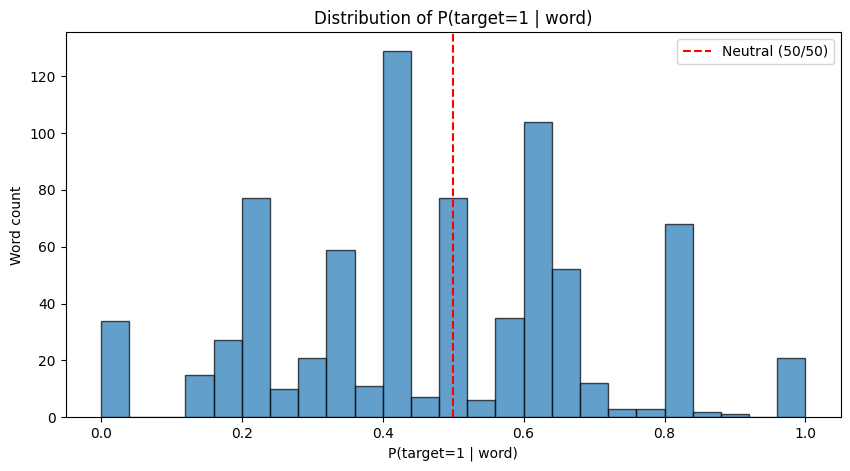

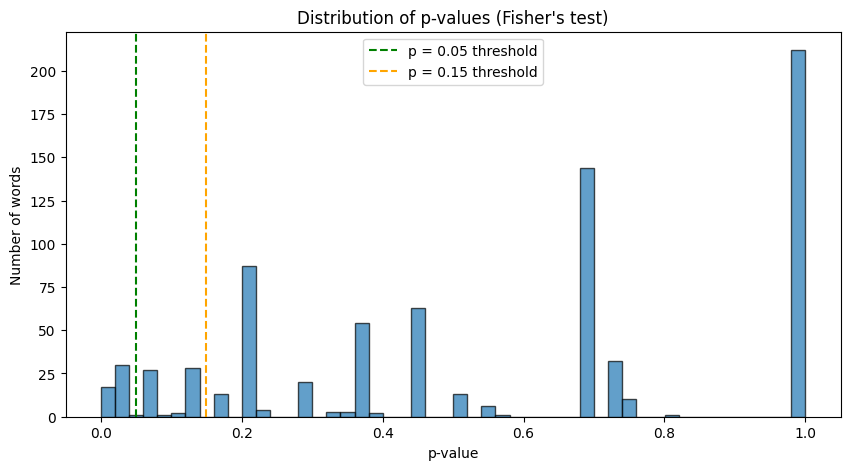

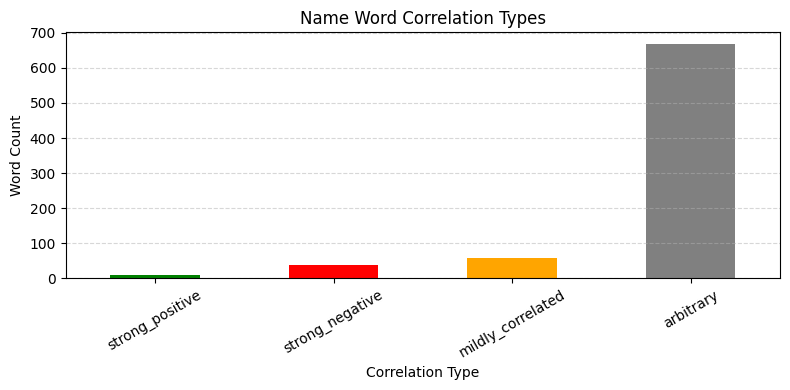

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import re
from scipy.stats import fisher_exact

# === Tokenize names into lowercase words ===
def tokenize_name(name):
    return re.findall(r"\b\w+\b", name.lower())

# Tokenize names
X["name_tokens"] = X["Name"].apply(tokenize_name)

# Count occurrences by class
word_counts = defaultdict(lambda: [0, 0])  # word: [count_class_0, count_class_1]

for tokens, label in zip(X["name_tokens"], y):
    for token in set(tokens):  # avoid multiple counts for same word in same name
        word_counts[token][label] += 1

# Create stats DataFrame
records = []
n_class_0 = sum(y == 0)
n_class_1 = sum(y == 1)

for word, (count_0, count_1) in word_counts.items():
    total = count_0 + count_1
    if total < 5:  # filter very rare words
        continue
    p1 = count_1 / total

    # Fisher's Exact Test
    table = [[count_1, count_0],
             [n_class_1 - count_1, n_class_0 - count_0]]
    _, p_value = fisher_exact(table)

    records.append({
        "word": word,
        "count_0": count_0,
        "count_1": count_1,
        "total_occurrence": total,
        "class1_rate": p1,
        "p_value": p_value
    })

word_df = pd.DataFrame(records)

# === Categorize correlation type ===
def categorize(row):
    if row["p_value"] < 0.05:
        if row["class1_rate"] > 0.6:
            return "strong_positive"
        elif row["class1_rate"] < 0.4:
            return "strong_negative"
        else:
            return "mildly_correlated"
    elif 0.05 <= row["p_value"] < 0.15:
        return "mildly_correlated"
    else:
        return "arbitrary"

word_df["correlation_type"] = word_df.apply(categorize, axis=1)

# === Summary counts
summary_counts = word_df["correlation_type"].value_counts().reindex(
    ["strong_positive", "strong_negative", "mildly_correlated", "arbitrary"], fill_value=0
)

# === Output top words per category
print("✅ Strongly Correlated Words (Significant & polarized):")
display(word_df[word_df["correlation_type"].isin(["strong_positive", "strong_negative"])]
        .sort_values("p_value").head(10))

print("🧐 Mildly Correlated Words (p ≈ 0.05–0.15):")
display(word_df[word_df["correlation_type"] == "mildly_correlated"]
        .sort_values("p_value").head(10))

print("⚪ Arbitrary Words (p > 0.15):")
display(word_df[word_df["correlation_type"] == "arbitrary"]
        .sort_values("total_occurrence", ascending=False).head(10))

# === Plot 1: Histogram of class1_rate
plt.figure(figsize=(10, 5))
plt.hist(word_df["class1_rate"], bins=25, alpha=0.7, edgecolor='k')
plt.axvline(0.5, color='red', linestyle='--', label="Neutral (50/50)")
plt.title("Distribution of P(target=1 | word)")
plt.xlabel("P(target=1 | word)")
plt.ylabel("Word count")
plt.legend()
plt.show()

# === Plot 2: P-value distribution
plt.figure(figsize=(10, 5))
plt.hist(word_df["p_value"], bins=50, alpha=0.7, edgecolor='k')
plt.axvline(0.05, color='green', linestyle='--', label="p = 0.05 threshold")
plt.axvline(0.15, color='orange', linestyle='--', label="p = 0.15 threshold")
plt.title("Distribution of p-values (Fisher's test)")
plt.xlabel("p-value")
plt.ylabel("Number of words")
plt.legend()
plt.show()

# === Plot 3: Correlation type summary bar chart
plt.figure(figsize=(8, 4))
summary_counts.plot(kind="bar", color=["green", "red", "orange", "gray"])
plt.title("Name Word Correlation Types")
plt.ylabel("Word Count")
plt.xlabel("Correlation Type")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [23]:
# reload_utils()
# from utils.eda import feature_eda_vis
# # === deep EDA for features on ETL-applied dataset ===
# feature_eda_vis(X[["Name"]], y, task_type)

In [41]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import numpy as np
# from scipy import stats
# from statsmodels.stats.proportion import proportion_confint

# # Assume X and y are pandas DataFrames/Series as described by the user.
# # For demonstration, let's create some sample data if X and y are not defined
# # (Remove or comment this out if you have your actual X and y)
# if 'X' not in locals() or 'y' not in locals():
#     print("Generating sample X and y for demonstration purposes...")
#     n_samples = 200
#     X_data = {
#         'HomePlanet': np.random.choice(['Earth', 'Europa', 'Mars', 'PlanetX', 'PlanetY'], size=n_samples), # Added more categories
#         'CryoSleep': np.random.choice([True, False, np.nan], size=n_samples, p=[0.25, 0.7, 0.05]), # Added NaNs
#         'Age': np.random.normal(loc=30, scale=10, size=n_samples).clip(0, 80),
#         'RoomService': np.random.exponential(scale=100, size=n_samples).clip(0, 2000) * np.random.choice([0,1, np.nan], size=n_samples, p=[0.35,0.55, 0.1]), # Some zeros and NaNs
#         'VIP': np.random.choice([True, False, np.nan], size=n_samples, p=[0.05, 0.85, 0.1]) # With NaNs
#     }
#     X = pd.DataFrame(X_data)
#     X['Age'] = X['Age'].astype(float).fillna(X['Age'].median()).astype(int) # Handle potential NaNs from clip then fill
#     X['RoomService'] = X['RoomService'].astype(float)
    
#     # Simulate some dependency for y
#     y_score = X['Age'] * -0.1 + X['RoomService'].fillna(0) * 0.01 + \
#               (X['HomePlanet'] == 'Europa').astype(int) * 20 + \
#               X['CryoSleep'].fillna(False).astype(int) * 30 # Handle NaNs in CryoSleep for scoring
#     y_prob = 1 / (1 + np.exp(- (y_score - y_score.mean()) / y_score.std() )) # Sigmoid
#     y = pd.Series(np.random.binomial(1, y_prob, size=n_samples).astype(bool), name='Transported')


# # --- Data Preparation ---
# y_named = y.copy()
# if not hasattr(y_named, 'name') or y_named.name is None:
#     y_named.name = 'Transported' # Default name if y has no name

# df_combined = X.copy()
# df_combined['Transported_numeric'] = y_named.astype(int)

# CATEGORICAL_THRESHOLD = 20 
# palette = {0: 'skyblue', 1: 'salmon'} 
# legend_labels = {0: 'Not Transported', 1: 'Transported'}
# feature_columns = X.columns

# # --- Main Loop for Plotting ---
# for feature_col in feature_columns:
#     print(f"--- Analyzing Feature: {feature_col} ---")
    
#     fig, axes = plt.subplots(2, 3, figsize=(22, 13)) # Adjusted figsize slightly for better label spacing
#     fig.suptitle(f'Comprehensive Analysis: {feature_col} | Target: {y_named.name}', fontsize=18, y=0.99) # Adjusted y for suptitle
    
#     # --- Row 1: Distribution Visualizations ---
#     ax_1_1 = axes[0, 0]
#     try:
#         plot_data_1_1 = df_combined[[feature_col, 'Transported_numeric']].dropna(subset=[feature_col])
#         if not plot_data_1_1.empty and plot_data_1_1[feature_col].nunique() > 0 :
#             sns.stripplot(data=plot_data_1_1, x=feature_col, y='Transported_numeric', hue='Transported_numeric',
#                           jitter=0.25, dodge=True, ax=ax_1_1, palette=palette, legend=False, alpha=0.6)
#             ax_1_1.set_title('Point Distribution by Target')
#             ax_1_1.set_ylabel(f'{y_named.name} (0=F, 1=T)')
#             ax_1_1.set_yticks([0, 1])
#             ax_1_1.set_yticklabels(['False', 'True'])
#             ax_1_1.set_xlabel(feature_col)
#             handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[i], markersize=10) for i in palette]
#             ax_1_1.legend(handles, [legend_labels[i] for i in palette], title=y_named.name, loc='best')
            
#             # Rotate x-axis labels if needed
#             if plot_data_1_1[feature_col].nunique() > 5 and plot_data_1_1[feature_col].dtype == 'object': # More categories
#                  ax_1_1.tick_params(axis='x', rotation=45, labelbottom=True)
#                  plt.setp(ax_1_1.get_xticklabels(), ha="right", rotation_mode="anchor")
#             elif plot_data_1_1[feature_col].nunique() > 10 and plot_data_1_1[feature_col].dtype != 'object': # Numerical with many ticks
#                  ax_1_1.tick_params(axis='x', rotation=30, labelbottom=True)
#                  plt.setp(ax_1_1.get_xticklabels(), ha="right", rotation_mode="anchor")
#             else: # Fewer categories or numerical, no rotation or default handling
#                  ax_1_1.tick_params(axis='x', labelbottom=True)

#         else:
#             ax_1_1.text(0.5, 0.5, "No data or no variance\nafter NaN drop", ha='center', va='center', transform=ax_1_1.transAxes)
#             ax_1_1.set_title('Point Distribution (No Data)')
#     except Exception as e:
#         ax_1_1.set_title('Point Distribution (Error)')
#         ax_1_1.text(0.5, 0.5, f"Plot failed: {e}", ha='center', va='center', transform=ax_1_1.transAxes, wrap=True)
#         print(f"  Error in Plot 1.1 for {feature_col}: {e}")

#     ax_1_2 = axes[0, 1]
#     try:
#         plot_data_1_2 = df_combined[[feature_col, 'Transported_numeric']].dropna(subset=[feature_col])
#         if not plot_data_1_2.empty and plot_data_1_2[feature_col].nunique() > 0:
#             sns.histplot(data=plot_data_1_2, x=feature_col, hue='Transported_numeric', 
#                          multiple='layer', kde=False, ax=ax_1_2, palette=palette, 
#                          stat="density", common_norm=False, alpha=0.6, legend=True)
#             ax_1_2.set_title('Normalized Histogram by Target')
#             ax_1_2.set_xlabel(feature_col)
#             handles_hist, labels_hist = ax_1_2.get_legend_handles_labels()
#             try: 
#                 labels_hist_descriptive = [legend_labels[int(float(l))] for l in labels_hist]
#                 ax_1_2.legend(handles_hist, labels_hist_descriptive, title=y_named.name)
#             except (ValueError, KeyError): 
#                  ax_1_2.legend(title=y_named.name)
#         else:
#             ax_1_2.text(0.5, 0.5, "No data or no variance\nafter NaN drop", ha='center', va='center', transform=ax_1_2.transAxes)
#             ax_1_2.set_title('Histogram (No Data)')
#     except Exception as e:
#         ax_1_2.set_title('Histogram (Error)')
#         ax_1_2.text(0.5, 0.5, f"Plot failed: {e}", ha='center', va='center', transform=ax_1_2.transAxes, wrap=True)
#         print(f"  Error in Plot 1.2 for {feature_col}: {e}")

#     ax_1_3 = axes[0, 2]
#     try:
#         temp_df_combined = df_combined.dropna(subset=[feature_col]) 
#         if not temp_df_combined.empty and temp_df_combined[feature_col].nunique() > 0:
#             is_categorical_like = temp_df_combined[feature_col].dtype == 'object' or \
#                                   temp_df_combined[feature_col].nunique() < CATEGORICAL_THRESHOLD
            
#             target_0_data = temp_df_combined[temp_df_combined['Transported_numeric'] == 0][feature_col]
#             target_1_data = temp_df_combined[temp_df_combined['Transported_numeric'] == 1][feature_col]

#             if not target_0_data.empty and not target_1_data.empty:
#                 if is_categorical_like:
#                     props_0 = target_0_data.value_counts(normalize=True)
#                     props_1 = target_1_data.value_counts(normalize=True)
#                     all_categories = sorted(list(set(props_0.index) | set(props_1.index)))
#                     props_0 = props_0.reindex(all_categories, fill_value=0)
#                     props_1 = props_1.reindex(all_categories, fill_value=0)
#                     diff_props = props_1 - props_0
#                     diff_props.plot(kind='bar', ax=ax_1_3, color=['tomato' if x < 0 else 'mediumseagreen' for x in diff_props.values]) # Removed rot here
#                     ax_1_3.tick_params(axis='x', rotation=45) # Apply rotation
#                     plt.setp(ax_1_3.get_xticklabels(), ha='right', rotation_mode='anchor') # Ensure alignment
#                     ax_1_3.set_ylabel('Prop(Y=1) - Prop(Y=0)')
#                 else: 
#                     min_val = min(target_0_data.min(), target_1_data.min())
#                     max_val = max(target_0_data.max(), target_1_data.max())
#                     if pd.isna(min_val) or pd.isna(max_val) or min_val == max_val: # Handle NaN or single value case
#                         bins = np.array([temp_df_combined[feature_col].min() - 0.5, temp_df_combined[feature_col].max() + 0.5]) if temp_df_combined[feature_col].nunique() > 0 else np.array([0,1])
#                     else: 
#                         bins = np.linspace(min_val, max_val, 11)
#                     hist_0, _ = np.histogram(target_0_data.dropna(), bins=bins, density=True) # dropna within histogram
#                     hist_1, _ = np.histogram(target_1_data.dropna(), bins=bins, density=True) # dropna within histogram
#                     diff_hist = hist_1 - hist_0
#                     bin_centers = (bins[:-1] + bins[1:]) / 2
#                     bar_width = bins[1] - bins[0] if len(bins) > 1 else 1
#                     ax_1_3.bar(bin_centers, diff_hist, width=bar_width * 0.9, 
#                                 color=['tomato' if x < 0 else 'mediumseagreen' for x in diff_hist])
#                     ax_1_3.set_ylabel('Density(Y=1) - Density(Y=0)')
#                 ax_1_3.axhline(0, color='black', lw=0.8, linestyle='--')
#                 ax_1_3.set_title('Outcome Difference by Feature Value')
#                 ax_1_3.set_xlabel(feature_col)
#             else:
#                 ax_1_3.text(0.5, 0.5, "Not enough data in one/both target groups", ha='center', va='center', transform=ax_1_3.transAxes)
#                 ax_1_3.set_title('Outcome Difference (Not enough data)')
#         else:
#             ax_1_3.text(0.5, 0.5, "No data or no variance\nafter NaN drop", ha='center', va='center', transform=ax_1_3.transAxes)
#             ax_1_3.set_title('Outcome Difference (No Data)')
#     except Exception as e:
#         ax_1_3.set_title('Outcome Difference (Error)')
#         ax_1_3.text(0.5, 0.5, f"Plot failed: {e}", ha='center', va='center', transform=ax_1_3.transAxes, wrap=True)
#         print(f"  Error in Plot 1.3 for {feature_col}: {e}")

#     # --- Row 2: Statistical Significance ---
#     ax_2_1 = axes[1, 0] 
#     ax_2_2 = axes[1, 1] 
#     ax_2_3 = axes[1, 2] 

#     for ax_text in [ax_2_2, ax_2_3]:
#         ax_text.clear()
#         ax_text.axis('off')

#     current_feature_data = df_combined[[feature_col, 'Transported_numeric']].dropna(subset=[feature_col])
#     if current_feature_data.empty or current_feature_data[feature_col].nunique() == 0: # Also check for no variance
#         ax_2_1.text(0.5, 0.5, "No data or no variance\nfor stats after NaN drop", ha='center', va='center', transform=ax_2_1.transAxes)
#         ax_2_1.set_title('Stats (No Data)')
#         ax_2_2.text(0.05, 0.9, "No data or no variance for stats after NaN drop.", fontsize=9, va='top', wrap=True)
#         ax_2_3.text(0.05, 0.9, "No data or no variance for stats after NaN drop.", fontsize=9, va='top', wrap=True)
#         fig.subplots_adjust(hspace=0.6, wspace=0.35, top=0.93, bottom=0.08, left=0.05, right=0.97)
#         plt.show()
#         continue 

#     is_categorical_feature = current_feature_data[feature_col].dtype == 'object' or \
#                              current_feature_data[feature_col].nunique() < CATEGORICAL_THRESHOLD
    
#     stats_summary_text = ""
#     interpretation_text = ""

#     if is_categorical_feature:
#         ax_2_1.set_title(f'Proportion Transported by {feature_col}\n(with 95% CIs)')
#         # Ensure feature_col is treated as string for crosstab if it's not already object (e.g. boolean, int categories)
#         contingency_table = pd.crosstab(current_feature_data[feature_col].astype(str), current_feature_data['Transported_numeric'])
        
#         if contingency_table.shape[0] < 1 or contingency_table.shape[1] < 2 : # Need at least 1 category and 2 outcome classes
#             stats_summary_text += "Chi-squared test not applicable (table too small or one outcome class missing).\n"
#             ax_2_1.text(0.5,0.5, "Too few categories or\noutcomes for plot/test", ha='center', va='center', transform=ax_2_1.transAxes)
#         elif contingency_table.shape[0] < 2: # Need at least 2 categories for chi2
#              stats_summary_text += "Chi-squared test not applicable (needs at least 2 categories).\n"
#              ax_2_1.text(0.5,0.5, "Needs at least 2 categories for Chi2 test", ha='center', va='center', transform=ax_2_1.transAxes)
#         else:
#             chi2, p_chi2, dof, expected = stats.chi2_contingency(contingency_table)
#             stats_summary_text += f"Chi-squared Test of Independence:\n"
#             stats_summary_text += f"  Chi2 Stat: {chi2:.2f}, P-value: {p_chi2:.3g}\n  DOF: {dof}\n"
#             interpretation_text += f"P-value ({p_chi2:.3g}) for Chi-squared test: "
#             interpretation_text += "Suggests " + ("a significant" if p_chi2 < 0.05 else "no significant") + \
#                                    f" association between {feature_col} and {y_named.name}.\n\n"

#             categories = contingency_table.index
#             proportions_transported = []
#             ci_lows = []
#             ci_highs = []
            
#             for cat in categories:
#                 count_transported = contingency_table.loc[cat, 1] if 1 in contingency_table.columns else 0
#                 count_not_transported = contingency_table.loc[cat, 0] if 0 in contingency_table.columns else 0
#                 n_obs_cat = count_transported + count_not_transported
#                 if n_obs_cat > 0:
#                     prop = count_transported / n_obs_cat
#                     low, high = proportion_confint(count_transported, n_obs_cat, method='wilson')
#                     proportions_transported.append(prop)
#                     ci_lows.append(low)
#                     ci_highs.append(high)
#                 else: 
#                     proportions_transported.append(0)
#                     ci_lows.append(0)
#                     ci_highs.append(0)

#             prop_df = pd.DataFrame({
#                 'category': categories, # Already strings due to .astype(str) in crosstab
#                 'proportion_transported': proportions_transported,
#                 'ci_low': ci_lows,
#                 'ci_high': ci_highs
#             })
            
#             ax_2_1.bar(prop_df['category'], prop_df['proportion_transported'], 
#                        yerr=[prop_df['proportion_transported'] - prop_df['ci_low'], prop_df['ci_high'] - prop_df['proportion_transported']],
#                        capsize=5, color='mediumseagreen', alpha=0.7)
#             ax_2_1.set_ylabel(f'Proportion {y_named.name}')
#             ax_2_1.tick_params(axis='x', rotation=45) # Corrected: Apply rotation
#             plt.setp(ax_2_1.get_xticklabels(), ha='right', rotation_mode='anchor') # Corrected: Ensure alignment
#             ax_2_1.axhline(current_feature_data['Transported_numeric'].mean(), color='grey', linestyle='--', label='Overall Mean')
#             if not prop_df.empty: # Only add legend if there's data to plot
#                 ax_2_1.legend(loc='best')

#             interpretation_text += "Error bars on plot show 95% CIs for proportion transported. "
#             interpretation_text += "If CIs for different categories don't overlap much, "
#             interpretation_text += "it suggests a significant difference in transport rates.\n"

#     else: # Numerical feature
#         group0 = current_feature_data[current_feature_data['Transported_numeric'] == 0][feature_col].dropna() # Ensure NaNs are out for tests
#         group1 = current_feature_data[current_feature_data['Transported_numeric'] == 1][feature_col].dropna() # Ensure NaNs are out for tests

#         ax_2_1.set_title(f'{feature_col} Distribution by Target')
#         # For boxplot, ensure data passed has NaNs handled if seaborn version is older
#         sns.boxplot(x='Transported_numeric', y=feature_col, data=current_feature_data.dropna(subset=[feature_col]), 
#                     ax=ax_2_1, palette=palette, hue='Transported_numeric', legend=False)
#         ax_2_1.set_xticklabels([legend_labels[0], legend_labels[1]])
#         ax_2_1.set_xlabel(y_named.name)

#         stats_summary_text += "Normality (Shapiro-Wilk):\n"
#         norm_p0, norm_p1 = -1.0, -1.0 # Initialize as float
#         if len(group0) >=3 : 
#             shapiro_stat0, norm_p0 = stats.shapiro(group0)
#             stats_summary_text += f"  Group 0 (Not Transported): p={norm_p0:.3g}\n"
#         else: stats_summary_text += "  Group 0: Too few samples for normality test.\n"
#         if len(group1) >=3 :
#             shapiro_stat1, norm_p1 = stats.shapiro(group1)
#             stats_summary_text += f"  Group 1 (Transported): p={norm_p1:.3g}\n"
#         else: stats_summary_text += "  Group 1: Too few samples for normality test.\n"
        
#         # Default to Mann-Whitney U if any group has < 3 samples for normality, or if normality fails
#         use_ttest = (norm_p0 > 0.05 or len(group0) < 3) and \
#                     (norm_p1 > 0.05 or len(group1) < 3)

#         if use_ttest and len(group0)>1 and len(group1)>1:
#             levene_stat, levene_p = stats.levene(group0, group1)
#             stats_summary_text += f"Homogeneity of Variances (Levene's test): p={levene_p:.3g}\n"
#             equal_var = levene_p > 0.05

#             t_stat, p_ttest = stats.ttest_ind(group0, group1, equal_var=equal_var) # nan_policy='omit' is default in newer scipy
#             stats_summary_text += f"Independent T-test (equal_var={equal_var}):\n"
#             stats_summary_text += f"  T-statistic: {t_stat:.2f}, P-value: {p_ttest:.3g}\n"
#             interpretation_text += f"P-value ({p_ttest:.3g}) from t-test: "
#             interpretation_text += "Suggests " + ("a significant" if p_ttest < 0.05 else "no significant") + \
#                                    f" difference in mean {feature_col} between groups.\n"
#             ax_2_1.text(0.5, 0.95, f"T-test p-value: {p_ttest:.3g}", ha='center', va='top', transform=ax_2_1.transAxes, fontsize=9, color='red', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

#         elif len(group0)>0 and len(group1)>0: 
#             try:
#                 u_stat, p_mannwhitney = stats.mannwhitneyu(group0, group1, alternative='two-sided') # nan_policy='omit' is default
#                 stats_summary_text += f"Mann-Whitney U Test:\n"
#                 stats_summary_text += f"  U-statistic: {u_stat:.0f}, P-value: {p_mannwhitney:.3g}\n"
#                 interpretation_text += f"P-value ({p_mannwhitney:.3g}) from Mann-Whitney U test: "
#                 interpretation_text += "Suggests " + ("a significant" if p_mannwhitney < 0.05 else "no significant") + \
#                                    f" difference in distributions of {feature_col} between groups.\n"
#                 ax_2_1.text(0.5, 0.95, f"Mann-Whitney p: {p_mannwhitney:.3g}", ha='center', va='top', transform=ax_2_1.transAxes, fontsize=9, color='red', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
#             except ValueError as e_mw: 
#                  stats_summary_text += f"Mann-Whitney U Test: Error - {e_mw}\n"
#                  interpretation_text += "Mann-Whitney U test could not be performed (e.g., identical data in groups).\n"
#         else:
#             stats_summary_text += "Not enough data in one or both groups for numerical tests.\n"
#             interpretation_text += "Not enough data to compare groups statistically.\n"

#     interpretation_text += "\nBayesian Perspective:\nA Bayesian approach could provide posterior distributions for parameters "
#     interpretation_text += "(e.g., difference in means/proportions). This offers a richer view of uncertainty "
#     interpretation_text += "and allows direct probability statements about the effect size, rather than just a p-value."

#     ax_2_2.text(0.01, 0.98, stats_summary_text, fontsize=8, va='top', ha='left', wrap=True, family='monospace') # Reduced font size
#     ax_2_2.set_title("Statistical Test Details", fontsize=10)
    
#     ax_2_3.text(0.01, 0.98, interpretation_text, fontsize=8, va='top', ha='left', wrap=True) # Reduced font size
#     ax_2_3.set_title("Interpretation & Bayesian Note", fontsize=10)

#     fig.subplots_adjust(hspace=0.7, wspace=0.4, top=0.93, bottom=0.12, left=0.06, right=0.97) # Adjusted spacing
#     plt.show()

# print("--- Finished generating all plots. ---")


In [8]:
# === Domain knowledge ===
# Any semantic/description of features?
# PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
# HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
# CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
# Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
# Destination - The planet the passenger will be debarking to.
# Age - The age of the passenger.
# VIP - Whether the passenger has paid for special VIP service during the voyage.
# RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
# Name - The first and last names of the passenger.
# Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [9]:
# from utils.eda import eda_feature_transformation_check
# recommendation = eda_feature_transformation_check(X, y, task_type)


In [10]:
# from utils.etl import run_recommended_etl, validate_X_schema, validate_y_schema
# from utils.eda import eda_vis
# etl_result = run_recommended_etl(dataset_name=local_dataset_name, target_column=target_column, \
#                                  recommendation=recommendation, task_type=task_type)
# X_train = etl_result["X_train"]
# y_train = etl_result["y_train"]
# X_val = etl_result["X_val"]
# y_val = etl_result["y_val"]

In [42]:
reload_utils()
from utils.etl import run_default_etl, run_custom_etl
etl_result = run_custom_etl(dataset_name=local_dataset_name, target_column=target_column)
X_train = etl_result["X_train"]
y_train = etl_result["y_train"]
X_val = etl_result["X_val"]
y_val = etl_result["y_val"]
print(etl_result["etl_description"])

🔁 Reloaded utils.etl, utils.eda, utils.eval, utils.submission
[PosixPath('/home/jovyan/data/space-titanic/raw/train.csv')]
Dataset loaded successfully. Only one file loaded
knnimpute, encode str to num, composite, drop, minmaxscale, ica


In [43]:
from utils.etl import validate_X_schema, validate_y_schema
validate_X_schema(X_train)
validate_X_schema(X_val)
validate_y_schema(y_train)
validate_y_schema(y_val)
# X_train.isna().sum()

✅ X schema valid.
✅ X schema valid.
✅ y schema valid.
✅ y schema valid.


In [44]:
print(X_train.shape)
print(X_val.shape)
# print(X_train.dtypes)

(6954, 52)
(1739, 52)


In [46]:
print(X_train.columns)

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'total_spent',
       'max_spend_category', 'deck', 'cabin_num', 'side',
       'name_corr_pos_p_value', 'name_corr_pos_prob', 'name_corr_neg_p_value',
       'name_corr_neg_prob', 'ica_1', 'ica_2', 'ica_3', 'ica_4', 'ica_5',
       'ica_6', 'ica_7', 'kmeans_dist_0', 'kmeans_dist_1', 'kmeans_dist_2',
       'kmeans_dist_3', 'kmeans_dist_4', 'kmeans_cluster',
       'gmm_cluster_prob_0', 'gmm_cluster_prob_1', 'gmm_cluster_prob_2',
       'gmm_cluster_prob_3', 'gmm_cluster_prob_4', 'has_used_RoomService',
       'RoomService_tp25', 'RoomService_tp50', 'RoomService_tp75',
       'has_used_FoodCourt', 'FoodCourt_tp25', 'FoodCourt_tp50',
       'FoodCourt_tp75', 'has_used_ShoppingMall', 'ShoppingMall_tp25',
       'ShoppingMall_tp50', 'ShoppingMall_tp75', 'has_used_Spa', 'Spa_tp25',
       'Spa_tp50', 'Spa_tp75', 'has_used_VRDeck', 'VRDeck_tp25', 'VRDeck_tp50',
       'VRDeck_tp75'],
      dtype='object')


In [110]:
# from utils.eda import eda_vis
# # === EDA again for ETL applied dataset ===
# eda_vis(X_train, y_train, task_type)

In [47]:
# reload_utils()
# from utils.eda import feature_eda_vis
# # === deep EDA for features on ETL-applied dataset ===
# print(X_train["CryoSleep"].value_counts(dropna=False))

# feature_eda_vis(X_train, y_train, task_type)

In [15]:
# X_train.shape

In [50]:
reload_utils()
from utils.eval import evaluate_feature_feedback

feedback = evaluate_feature_feedback(
    X_train,
    y_train,
    X_val,
    y_val,
    auto_tune_threshold=False,  # 🔍 enable random search
    drop_threshold=0.04,
    n_trials=30,
    auto_drop=True,
)

# Use the optimized result
# X_train = feedback["X_train_clean"]
# X_val = feedback["X_val_clean"]


🔁 Reloaded utils.etl, utils.eda, utils.eval, utils.submission
✅ RandomForest Accuracy (original): 0.7671

📊 Top 10 Features by RF Importance:


,feature,rf_importance,mutual_info,pearson_corr
27,gmm_cluster_prob_0,0.084542,0.026827,-0.043586
19,ica_6,0.062987,0.181119,-0.483854
5,total_spent,0.053176,0.133522,-0.200077
23,kmeans_dist_2,0.048285,0.110704,-0.423945
22,kmeans_dist_1,0.046924,0.111357,0.403972
14,ica_1,0.045980,0.124571,0.080091
6,max_spend_category,0.040505,0.083588,-0.374311
21,kmeans_dist_0,0.039262,0.103029,-0.400364
28,gmm_cluster_prob_1,0.035206,0.088315,-0.383675
17,ica_4,0.034617,0.056365,0.208079



🧹 Least Informative Features (below threshold):
['kmeans_dist_0', 'gmm_cluster_prob_1', 'ica_4', 'ica_7', 'ica_2', 'kmeans_dist_4', 'gmm_cluster_prob_4', 'ica_3', 'ica_5', 'cabin_num', 'kmeans_dist_3', 'gmm_cluster_prob_2', 'Age', 'CryoSleep', 'gmm_cluster_prob_3', 'RoomService_tp75', 'has_used_RoomService', 'deck', 'name_corr_neg_prob', 'name_corr_neg_p_value', 'kmeans_cluster', 'HomePlanet', 'has_used_Spa', 'name_corr_pos_prob', 'RoomService_tp50', 'Spa_tp50', 'name_corr_pos_p_value', 'RoomService_tp25', 'Spa_tp75', 'side', 'Destination', 'has_used_VRDeck', 'VRDeck_tp25', 'VRDeck_tp75', 'VRDeck_tp50', 'Spa_tp25', 'ShoppingMall_tp50', 'has_used_ShoppingMall', 'ShoppingMall_tp75', 'FoodCourt_tp75', 'FoodCourt_tp25', 'has_used_FoodCourt', 'FoodCourt_tp50', 'ShoppingMall_tp25', 'VIP']


,feature,rf_importance,mutual_info,pearson_corr
45,Spa_tp25,0.003191,0.061448,-0.351940
42,ShoppingMall_tp50,0.002670,0.031664,-0.262984
40,has_used_ShoppingMall,0.002601,0.031711,-0.262984
43,ShoppingMall_tp75,0.002595,0.019127,-0.166565
39,FoodCourt_tp75,0.002510,0.000000,-0.110415
37,FoodCourt_tp25,0.002134,0.033475,-0.237233
36,has_used_FoodCourt,0.001996,0.036254,-0.237233
38,FoodCourt_tp50,0.001925,0.028676,-0.237233
41,ShoppingMall_tp25,0.001767,0.036050,-0.262984
4,VIP,0.000312,0.012699,-0.035961



🔁 RandomForest Accuracy after dropping: 0.7579
🔴 Degraded by -0.0092


##### from utils.etl import validate_X_schema, validate_y_schema
validate_X_schema(X_train)
validate_X_schema(X_val)
validate_y_schema(y_train)
validate_y_schema(y_val)

In [27]:
from utils.models import get_sklearn_model, get_nn_model
from utils.train import train_sklearn_model, train_nn_model, log_model_artifact, log_final_metrics, evaluate_model, \
                        conditionally_encode_labels
import mlflow
os.environ["WANDB_BASE_URL"] = "http://wandb:8080"
os.environ["WANDB_DEBUG"] = "true"
os.environ["WANDB_DEBUG_LOG_PATH"] = "/tmp/wandb_debug.log"
import wandb
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Define model sweep
print("defining sweep")
model_configs = {
    # "decision_tree": [
    #     {"criterion": c, "max_depth": d, "min_samples_split": m, "min_samples_leaf": l}
    #     for c in ["gini", "entropy"]
    #     for d in [None, 5, 10]
    #     for m in [2, 5]
    #     for l in [1, 2]
    # ],

    "random_forest": [
        {"n_estimators": n, "max_depth": d, "max_features": f, "min_samples_split": m}
        for n in [50, 200, 350]
        for d in [None, 10,15]
        for f in ["sqrt", "log2"]
        for m in [2, 5]
    ],

    # "logistic_regression": [
    #     {"penalty": p, "C": c, "solver": "liblinear", "max_iter": 200}
    #     for p in ["l1", "l2"]
    #     for c in [0.01, 0.1, 1.0]
    # ],

    "xgboost": [
        {"n_estimators": n, "max_depth": d, "learning_rate": lr, "subsample": s, "colsample_bytree": cbt}
        for n in [200]
        for d in [5, 7]
        for lr in [0.005, 0.1]
        for s in [0.8, 1.0]
        for cbt in [0.8, 1.0]
    ],

    "lightgbm": [
        {"n_estimators": n, "max_depth": d, "learning_rate": lr, "num_leaves": nl, "min_child_samples": mcs}
        for n in [100, 200]
        for d in [-1, 10]
        for lr in [0.01, 0.1]
        for nl in [31, 50]
        for mcs in [10, 20]
    ],
    # "svm": [
    #     {"C": c, "kernel": k, "gamma": g}
    #     for c in [0.1, 1.0, 10.0]
    #     for k in ["linear", "rbf", "poly"]
    #     for g in ["scale", "auto"]
    # ],

    # "naive_bayes": [
    #     {"var_smoothing": vs}
    #     for vs in [1e-9, 1e-8, 1e-7]
    # ],

    # "knn": [
    #     {"n_neighbors": k, "weights": w, "metric": m}
    #     for k in [ 5, 7]
    #     for w in ["uniform", "distance"]
    #     for m in ["euclidean", "manhattan"]
    # ],
    # "neural_net": [
    #     {
    #         "model_type": mt,
    #         "hidden": h,
    #         "dropout": d,
    #         "activation": act,
    #         "batch_norm": bn,
    #         "lr": lr,
    #         "num_layers": nl
    #     }
    #     for mt in ["mlp", "lstm", "cnn"]
    #     for h in [32, 64]
    #     for d in [0.0, 0.3]
    #     for act in ["relu", "tanh"]
    #     for bn in [False, True]
    #     for lr in [.005, 0.001, .05, 0.01, .05]
    #     for nl in [1, 2, 3,4]
    # ],
}

mlflow.set_experiment(f"kaggle_{local_dataset_name}")
print("starting experiments")
# Loop over each model and its hyperparam
for model_name, config_list in model_configs.items():
    for params in config_list:
        # Terminate any already running experiments (MLflow and W&B)
        if mlflow.active_run() is not None:
            mlflow.end_run()
        wandb.finish()
        # === Init Experiment | MLflow and W&B ===
        run_name = f"{etl_result['etl_version']}_{model_name}_{params}"
        run = mlflow.start_run(run_name=run_name)
        mlflow.log_param("model_name", model_name)
        mlflow.log_params(params)
        mlflow.log_param("task_type", task_type)
        mlflow.log_param("perf_eval_metric", perf_eval_metric)
        mlflow.log_param("etl_version", etl_result['etl_version'])
        mlflow.log_param("etl_description", etl_result['etl_description'])
        print("Started MLflow run:", run.info.run_id)
        wandb.init(
            project=f"kaggle_{local_dataset_name}",
            name=run_name,
            config={
                **params,
                "model_name": model_name,
                "task_type": task_type,
                "perf_eval_metric": perf_eval_metric,
                "etl_version": etl_result['etl_version'],
                "etl_description": etl_result['etl_description']
            }
        )
        # === Train ===
        if model_name == "neural_net":
            output_dim = y_train.nunique() if task_type == "multiclass_classification" else 1
            model, lr = get_nn_model(X_train.shape[1], output_dim=output_dim, **params)
            y_train_nn, y_val_nn, label_encoder, label_encoder_applied = conditionally_encode_labels(y_train, y_val)
            model, y_pred = train_nn_model(
                model, X_train, y_train_nn, X_val, y_val_nn,
                epochs=20,
                lr = lr,
                task_type=task_type,
                eval_metric_name=eval_metric_name,
                eval_metric_fn=eval_metric_fn,
            )
            if label_encoder_applied:
                y_pred = label_encoder.inverse_transform(y_pred)
            print("✅ Finished training neural net")

        else:
            model = get_sklearn_model(model_name, **params)
            trained_model, y_pred = train_sklearn_model(
                model, X_train, y_train, X_val, y_val,
                task_type=task_type,
            )
            print("✅ Finished training sklearn model")

        # === Evaluate & log ===
        eval_metrics = evaluate_model(y_val, y_pred, task_type)
        log_final_metrics(eval_metrics)
        # commented out to reduced write2dis
        # log_model_artifact(trained_model, model_name, framework="torch" if model_name == "neural_net" else "sklearn")

        # === End Experiment | MLflow and W&B ===
        mlflow.end_run()
        wandb.finish()



defining sweep
starting experiments
Started MLflow run: 1c4b0ce2b7e4453bbbb7165d29438098


wandb: You can find your API key in your browser here: http://wandb:8080/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

  ········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for wandb:8080 to your netrc file: /home/jovyan/.netrc
wandb: Currently logged in as: ben to http://wandb:8080. Use `wandb login --relogin` to force relogin


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 50, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2} at: http://mlflow:5000/#/experiments/2/runs/1c4b0ce2b7e4453bbbb7165d29438098
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.77803
f1_macro,0.778
f1_weighted,0.77797
precision_weighted,0.77866
recall_weighted,0.77803


Started MLflow run: c6e05e1c435e400da5a576dd719918ec


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 50, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5} at: http://mlflow:5000/#/experiments/2/runs/c6e05e1c435e400da5a576dd719918ec
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.77688
f1_macro,0.77688
f1_weighted,0.77687
precision_weighted,0.7772
recall_weighted,0.77688


Started MLflow run: 87be43ecd6834b77b4061169dc6d6b73


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 50, 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 2} at: http://mlflow:5000/#/experiments/2/runs/87be43ecd6834b77b4061169dc6d6b73
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.77286
f1_macro,0.77281
f1_weighted,0.77278
precision_weighted,0.77357
recall_weighted,0.77286


Started MLflow run: 9d6d2359333c4b198fbca3e69f76fd2e


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 50, 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 5} at: http://mlflow:5000/#/experiments/2/runs/9d6d2359333c4b198fbca3e69f76fd2e
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.77343
f1_macro,0.77343
f1_weighted,0.77342
precision_weighted,0.77374
recall_weighted,0.77343


Started MLflow run: c5d2c88e21164219b44450c1cc1d2ccc


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 50, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2} at: http://mlflow:5000/#/experiments/2/runs/c5d2c88e21164219b44450c1cc1d2ccc
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78206
f1_macro,0.78183
f1_weighted,0.7819
precision_weighted,0.78253
recall_weighted,0.78206


Started MLflow run: f1e99b1edcc34931a30da418a658ec76


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 50, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5} at: http://mlflow:5000/#/experiments/2/runs/f1e99b1edcc34931a30da418a658ec76
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78723
f1_macro,0.78715
f1_weighted,0.78719
precision_weighted,0.78731
recall_weighted,0.78723


Started MLflow run: edac5dcb967d4142926cfab6757cc124


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 50, 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 2} at: http://mlflow:5000/#/experiments/2/runs/edac5dcb967d4142926cfab6757cc124
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78493
f1_macro,0.7849
f1_weighted,0.78492
precision_weighted,0.78493
recall_weighted,0.78493


Started MLflow run: 89f8c47bf8c5403fb72c20f41c14002f


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 50, 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 5} at: http://mlflow:5000/#/experiments/2/runs/89f8c47bf8c5403fb72c20f41c14002f
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.77458
f1_macro,0.77445
f1_weighted,0.7745
precision_weighted,0.77476
recall_weighted,0.77458


Started MLflow run: 37e02226d01a4848900f7556a7b24252


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 50, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 2} at: http://mlflow:5000/#/experiments/2/runs/37e02226d01a4848900f7556a7b24252
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78033
f1_macro,0.78033
f1_weighted,0.78033
precision_weighted,0.78057
recall_weighted,0.78033


Started MLflow run: 9aa70c33fd6447e68f1ea191d18bc59a


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 50, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 5} at: http://mlflow:5000/#/experiments/2/runs/9aa70c33fd6447e68f1ea191d18bc59a
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.77803
f1_macro,0.77803
f1_weighted,0.77803
precision_weighted,0.7782
recall_weighted,0.77803


Started MLflow run: f82987353aeb46aea730a14a699cdbee


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 50, 'max_depth': 15, 'max_features': 'log2', 'min_samples_split': 2} at: http://mlflow:5000/#/experiments/2/runs/f82987353aeb46aea730a14a699cdbee
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78493
f1_macro,0.78493
f1_weighted,0.78492
precision_weighted,0.78525
recall_weighted,0.78493


Started MLflow run: 5809ca50f1f1417a9195506c79efd08b


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 50, 'max_depth': 15, 'max_features': 'log2', 'min_samples_split': 5} at: http://mlflow:5000/#/experiments/2/runs/5809ca50f1f1417a9195506c79efd08b
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.77803
f1_macro,0.77803
f1_weighted,0.77803
precision_weighted,0.77827
recall_weighted,0.77803


Started MLflow run: 0739548cec904e19b52771bd4745311e


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 200, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2} at: http://mlflow:5000/#/experiments/2/runs/0739548cec904e19b52771bd4745311e
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.77631
f1_macro,0.77628
f1_weighted,0.77626
precision_weighted,0.77684
recall_weighted,0.77631


Started MLflow run: f4a88e096c34495bba45397a4d79a508


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 200, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5} at: http://mlflow:5000/#/experiments/2/runs/f4a88e096c34495bba45397a4d79a508
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.77861
f1_macro,0.77859
f1_weighted,0.77857
precision_weighted,0.77909
recall_weighted,0.77861


Started MLflow run: 131f80a761fb442c8210d3f4c402f89d


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 200, 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 2} at: http://mlflow:5000/#/experiments/2/runs/131f80a761fb442c8210d3f4c402f89d
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.77861
f1_macro,0.77856
f1_weighted,0.77853
precision_weighted,0.7794
recall_weighted,0.77861


Started MLflow run: 698da77829ff4a6f94018f12cafe4cf0


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 200, 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 5} at: http://mlflow:5000/#/experiments/2/runs/698da77829ff4a6f94018f12cafe4cf0
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.77516
f1_macro,0.77514
f1_weighted,0.77512
precision_weighted,0.77564
recall_weighted,0.77516


Started MLflow run: d58de09b0db0417a979f2f04d1d5042a


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2} at: http://mlflow:5000/#/experiments/2/runs/d58de09b0db0417a979f2f04d1d5042a
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78148
f1_macro,0.7813
f1_weighted,0.78136
precision_weighted,0.78183
recall_weighted,0.78148


Started MLflow run: 2cce2536fe714b02937240df646c2a3f


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5} at: http://mlflow:5000/#/experiments/2/runs/2cce2536fe714b02937240df646c2a3f
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78436
f1_macro,0.78422
f1_weighted,0.78427
precision_weighted,0.78457
recall_weighted,0.78436


Started MLflow run: 85fd00d39d7945aaa38b0a53d8ed565c


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 200, 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 2} at: http://mlflow:5000/#/experiments/2/runs/85fd00d39d7945aaa38b0a53d8ed565c
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78148
f1_macro,0.78131
f1_weighted,0.78137
precision_weighted,0.78179
recall_weighted,0.78148


Started MLflow run: a6404df7e2354868b280955d1748d824


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 200, 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 5} at: http://mlflow:5000/#/experiments/2/runs/a6404df7e2354868b280955d1748d824
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.77976
f1_macro,0.77956
f1_weighted,0.77963
precision_weighted,0.78013
recall_weighted,0.77976


Started MLflow run: 68628b6df08d409c965c44b60e3f3d49


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 200, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 2} at: http://mlflow:5000/#/experiments/2/runs/68628b6df08d409c965c44b60e3f3d49
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.77976
f1_macro,0.77975
f1_weighted,0.77974
precision_weighted,0.7801
recall_weighted,0.77976


Started MLflow run: 1afad82f904540fd9b156014c84b0679


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 200, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 5} at: http://mlflow:5000/#/experiments/2/runs/1afad82f904540fd9b156014c84b0679
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78091
f1_macro,0.78091
f1_weighted,0.7809
precision_weighted,0.78112
recall_weighted,0.78091


Started MLflow run: fc1fcfd50a03493c984ad1d058f6e3bb


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 200, 'max_depth': 15, 'max_features': 'log2', 'min_samples_split': 2} at: http://mlflow:5000/#/experiments/2/runs/fc1fcfd50a03493c984ad1d058f6e3bb
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.77976
f1_macro,0.77974
f1_weighted,0.77972
precision_weighted,0.78024
recall_weighted,0.77976


Started MLflow run: 1a54be7c6e9b4bb881d3c5a08c57351e


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 200, 'max_depth': 15, 'max_features': 'log2', 'min_samples_split': 5} at: http://mlflow:5000/#/experiments/2/runs/1a54be7c6e9b4bb881d3c5a08c57351e
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78091
f1_macro,0.78091
f1_weighted,0.7809
precision_weighted,0.78112
recall_weighted,0.78091


Started MLflow run: 2813c42225474c57b316e827ef08c08e


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 350, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2} at: http://mlflow:5000/#/experiments/2/runs/2813c42225474c57b316e827ef08c08e
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78321
f1_macro,0.78317
f1_weighted,0.78314
precision_weighted,0.78394
recall_weighted,0.78321


Started MLflow run: c6d3ad3c231a4a979d1ec3170d60a02d


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 350, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5} at: http://mlflow:5000/#/experiments/2/runs/c6d3ad3c231a4a979d1ec3170d60a02d
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.77343
f1_macro,0.77343
f1_weighted,0.77342
precision_weighted,0.7737
recall_weighted,0.77343


Started MLflow run: d9f7099ec18440658d138486c61697e3


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 350, 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 2} at: http://mlflow:5000/#/experiments/2/runs/d9f7099ec18440658d138486c61697e3
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78263
f1_macro,0.7826
f1_weighted,0.78257
precision_weighted,0.78333
recall_weighted,0.78263


Started MLflow run: 03e0af408e09407c854fae177473b8df


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 350, 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 5} at: http://mlflow:5000/#/experiments/2/runs/03e0af408e09407c854fae177473b8df
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.77803
f1_macro,0.778
f1_weighted,0.77797
precision_weighted,0.77866
recall_weighted,0.77803


Started MLflow run: 086d7a95019744b29afa7cbb0c4454bd


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 350, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2} at: http://mlflow:5000/#/experiments/2/runs/086d7a95019744b29afa7cbb0c4454bd
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78148
f1_macro,0.7814
f1_weighted,0.78144
precision_weighted,0.78156
recall_weighted,0.78148


Started MLflow run: cb5d79e8a5fd48de851c75adc551f387


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 350, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5} at: http://mlflow:5000/#/experiments/2/runs/cb5d79e8a5fd48de851c75adc551f387
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78378
f1_macro,0.78364
f1_weighted,0.78369
precision_weighted,0.78401
recall_weighted,0.78378


Started MLflow run: 40dd5da4c296482ab75417e94f4734bc


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 350, 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 2} at: http://mlflow:5000/#/experiments/2/runs/40dd5da4c296482ab75417e94f4734bc
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.77976
f1_macro,0.77965
f1_weighted,0.7797
precision_weighted,0.77987
recall_weighted,0.77976


Started MLflow run: 0665e0b70a814cdaa6276006ca61d128


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 350, 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 5} at: http://mlflow:5000/#/experiments/2/runs/0665e0b70a814cdaa6276006ca61d128
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78091
f1_macro,0.78068
f1_weighted,0.78075
precision_weighted,0.78138
recall_weighted,0.78091


Started MLflow run: 245c4524b66b47d58ede696585f2f8aa


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 350, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 2} at: http://mlflow:5000/#/experiments/2/runs/245c4524b66b47d58ede696585f2f8aa
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.77746
f1_macro,0.77746
f1_weighted,0.77745
precision_weighted,0.77771
recall_weighted,0.77746


Started MLflow run: c27c4b452d594c0db0f69b580792b058


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 350, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 5} at: http://mlflow:5000/#/experiments/2/runs/c27c4b452d594c0db0f69b580792b058
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78091
f1_macro,0.7809
f1_weighted,0.78089
precision_weighted,0.78125
recall_weighted,0.78091


Started MLflow run: 7138c375b66e4b42b18639ed5b5d01d0


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 350, 'max_depth': 15, 'max_features': 'log2', 'min_samples_split': 2} at: http://mlflow:5000/#/experiments/2/runs/7138c375b66e4b42b18639ed5b5d01d0
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78033
f1_macro,0.78031
f1_weighted,0.78028
precision_weighted,0.7809
recall_weighted,0.78033


Started MLflow run: f1f07fe9ad9c451aa2b29e02d8f40803


✅ Labels already normalized, no encoding needed
✅ Finished training sklearn model
🏃 View run v31_random_forest_{'n_estimators': 350, 'max_depth': 15, 'max_features': 'log2', 'min_samples_split': 5} at: http://mlflow:5000/#/experiments/2/runs/f1f07fe9ad9c451aa2b29e02d8f40803
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.77803
f1_macro,0.77803
f1_weighted,0.77803
precision_weighted,0.7782
recall_weighted,0.77803


Started MLflow run: a456338f88d741e5b8643106f8278468


✅ Labels already normalized, no encoding needed


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:04:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Finished training sklearn model
🏃 View run v31_xgboost_{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.005, 'subsample': 0.8, 'colsample_bytree': 0.8} at: http://mlflow:5000/#/experiments/2/runs/a456338f88d741e5b8643106f8278468
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78091
f1_macro,0.78018
f1_weighted,0.78031
precision_weighted,0.78329
recall_weighted,0.78091


Started MLflow run: bb6a1b1d884c45da8c09d3e735474a7c


✅ Labels already normalized, no encoding needed


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:04:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Finished training sklearn model
🏃 View run v31_xgboost_{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.005, 'subsample': 0.8, 'colsample_bytree': 1.0} at: http://mlflow:5000/#/experiments/2/runs/bb6a1b1d884c45da8c09d3e735474a7c
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.77746
f1_macro,0.77653
f1_weighted,0.77667
precision_weighted,0.78058
recall_weighted,0.77746


Started MLflow run: 7891b556eee14362a8a7b60a4ee150c2


✅ Labels already normalized, no encoding needed


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:04:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Finished training sklearn model
🏃 View run v31_xgboost_{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.005, 'subsample': 1.0, 'colsample_bytree': 0.8} at: http://mlflow:5000/#/experiments/2/runs/7891b556eee14362a8a7b60a4ee150c2
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.77976
f1_macro,0.77917
f1_weighted,0.77928
precision_weighted,0.78157
recall_weighted,0.77976


Started MLflow run: 94dfadc992c34f36a5e4e9620747f988


✅ Labels already normalized, no encoding needed


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:04:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Finished training sklearn model
🏃 View run v31_xgboost_{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.005, 'subsample': 1.0, 'colsample_bytree': 1.0} at: http://mlflow:5000/#/experiments/2/runs/94dfadc992c34f36a5e4e9620747f988
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.77918
f1_macro,0.77841
f1_weighted,0.77853
precision_weighted,0.78173
recall_weighted,0.77918


Started MLflow run: 248d6f3a72fb4344b4163c8fcc08194c


✅ Labels already normalized, no encoding needed


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:04:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Finished training sklearn model
🏃 View run v31_xgboost_{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8} at: http://mlflow:5000/#/experiments/2/runs/248d6f3a72fb4344b4163c8fcc08194c
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.80046
f1_macro,0.80046
f1_weighted,0.80046
precision_weighted,0.80058
recall_weighted,0.80046


Started MLflow run: 85d60c9227234d75a7c832dd7f9c7d59


✅ Labels already normalized, no encoding needed


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:04:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Finished training sklearn model
🏃 View run v31_xgboost_{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0} at: http://mlflow:5000/#/experiments/2/runs/85d60c9227234d75a7c832dd7f9c7d59
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.79126
f1_macro,0.79126
f1_weighted,0.79126
precision_weighted,0.79135
recall_weighted,0.79126


Started MLflow run: 152291f438f346bda2a78b5e3fface99


✅ Labels already normalized, no encoding needed


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:04:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Finished training sklearn model
🏃 View run v31_xgboost_{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8} at: http://mlflow:5000/#/experiments/2/runs/152291f438f346bda2a78b5e3fface99
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.79183
f1_macro,0.79183
f1_weighted,0.79184
precision_weighted,0.79188
recall_weighted,0.79183


Started MLflow run: efdcbe08e0e74795bedf91893c381c01


✅ Labels already normalized, no encoding needed


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:04:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Finished training sklearn model
🏃 View run v31_xgboost_{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0} at: http://mlflow:5000/#/experiments/2/runs/efdcbe08e0e74795bedf91893c381c01
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78838
f1_macro,0.78837
f1_weighted,0.78839
precision_weighted,0.7884
recall_weighted,0.78838


Started MLflow run: 5e3eea6c9f7e47d0b6d009e26021ed67


✅ Labels already normalized, no encoding needed


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:05:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Finished training sklearn model
🏃 View run v31_xgboost_{'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.005, 'subsample': 0.8, 'colsample_bytree': 0.8} at: http://mlflow:5000/#/experiments/2/runs/5e3eea6c9f7e47d0b6d009e26021ed67
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78206
f1_macro,0.78172
f1_weighted,0.78181
precision_weighted,0.78291
recall_weighted,0.78206


Started MLflow run: 36a1ad355aa8499891e199fbb8ae278d


✅ Labels already normalized, no encoding needed


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:05:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Finished training sklearn model
🏃 View run v31_xgboost_{'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.005, 'subsample': 0.8, 'colsample_bytree': 1.0} at: http://mlflow:5000/#/experiments/2/runs/36a1ad355aa8499891e199fbb8ae278d
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78321
f1_macro,0.78298
f1_weighted,0.78305
precision_weighted,0.78368
recall_weighted,0.78321


Started MLflow run: 1147c6a2c5584ea4aae7485b2aed906e


✅ Labels already normalized, no encoding needed


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:05:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Finished training sklearn model
🏃 View run v31_xgboost_{'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.005, 'subsample': 1.0, 'colsample_bytree': 0.8} at: http://mlflow:5000/#/experiments/2/runs/1147c6a2c5584ea4aae7485b2aed906e
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.77803
f1_macro,0.77784
f1_weighted,0.77791
precision_weighted,0.77837
recall_weighted,0.77803


Started MLflow run: 63af02ec4de74eb3952d9e51c867a771


✅ Labels already normalized, no encoding needed


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:05:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Finished training sklearn model
🏃 View run v31_xgboost_{'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.005, 'subsample': 1.0, 'colsample_bytree': 1.0} at: http://mlflow:5000/#/experiments/2/runs/63af02ec4de74eb3952d9e51c867a771
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.77631
f1_macro,0.77621
f1_weighted,0.77626
precision_weighted,0.77639
recall_weighted,0.77631


Started MLflow run: c370a3ce039649c9a7d57b329dea883f


✅ Labels already normalized, no encoding needed


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:05:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Finished training sklearn model
🏃 View run v31_xgboost_{'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8} at: http://mlflow:5000/#/experiments/2/runs/c370a3ce039649c9a7d57b329dea883f
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78666
f1_macro,0.78666
f1_weighted,0.78665
precision_weighted,0.78688
recall_weighted,0.78666


Started MLflow run: 3658f1d5b0c141e7a90e02c93810d563


✅ Labels already normalized, no encoding needed


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:05:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Finished training sklearn model
🏃 View run v31_xgboost_{'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0} at: http://mlflow:5000/#/experiments/2/runs/3658f1d5b0c141e7a90e02c93810d563
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.79011
f1_macro,0.79009
f1_weighted,0.79007
precision_weighted,0.79061
recall_weighted,0.79011


Started MLflow run: a0963e735b244f268d65e42fa126fb4f


✅ Labels already normalized, no encoding needed


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:05:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Finished training sklearn model
🏃 View run v31_xgboost_{'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8} at: http://mlflow:5000/#/experiments/2/runs/a0963e735b244f268d65e42fa126fb4f
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78896
f1_macro,0.78896
f1_weighted,0.78895
precision_weighted,0.78918
recall_weighted,0.78896


Started MLflow run: f22ceb89f3884fe7b96782d239cbcb4f


✅ Labels already normalized, no encoding needed


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:05:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Finished training sklearn model
🏃 View run v31_xgboost_{'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0} at: http://mlflow:5000/#/experiments/2/runs/f22ceb89f3884fe7b96782d239cbcb4f
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.79068
f1_macro,0.79068
f1_weighted,0.79069
precision_weighted,0.79082
recall_weighted,0.79068


Started MLflow run: 7d9b137370024585bf1d423730c8d245


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.01, 'num_leaves': 31, 'min_child_samples': 10} at: http://mlflow:5000/#/experiments/2/runs/7d9b137370024585bf1d423730c8d245
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78378
f1_macro,0.78293
f1_weighted,0.78306
precision_weighted,0.78678
recall_weighted,0.78378


Started MLflow run: 312eed9886cc4899bf953ad7db769ba4


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.01, 'num_leaves': 31, 'min_child_samples': 20} at: http://mlflow:5000/#/experiments/2/runs/312eed9886cc4899bf953ad7db769ba4
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78723
f1_macro,0.78657
f1_weighted,0.78669
precision_weighted,0.7895
recall_weighted,0.78723


Started MLflow run: dc36941590b24bfd8c6ce06e54149507


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.01, 'num_leaves': 50, 'min_child_samples': 10} at: http://mlflow:5000/#/experiments/2/runs/dc36941590b24bfd8c6ce06e54149507
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.77861
f1_macro,0.77801
f1_weighted,0.77813
precision_weighted,0.78041
recall_weighted,0.77861


Started MLflow run: a2c8cf9cd3bd49a1aafc53adbb5a95ef


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.01, 'num_leaves': 50, 'min_child_samples': 20} at: http://mlflow:5000/#/experiments/2/runs/a2c8cf9cd3bd49a1aafc53adbb5a95ef
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.77976
f1_macro,0.77924
f1_weighted,0.77935
precision_weighted,0.78127
recall_weighted,0.77976


Started MLflow run: b77b781512c14c58a2dd590235a08eca


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.1, 'num_leaves': 31, 'min_child_samples': 10} at: http://mlflow:5000/#/experiments/2/runs/b77b781512c14c58a2dd590235a08eca
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.80046
f1_macro,0.80045
f1_weighted,0.80046
precision_weighted,0.8005
recall_weighted,0.80046


Started MLflow run: 7a37f728da274022aa1b8e31da780afc


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.1, 'num_leaves': 31, 'min_child_samples': 20} at: http://mlflow:5000/#/experiments/2/runs/7a37f728da274022aa1b8e31da780afc
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.79413
f1_macro,0.79408
f1_weighted,0.79412
precision_weighted,0.79415
recall_weighted,0.79413


Started MLflow run: 7432aef106444323bc45d058f42e0b42


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.1, 'num_leaves': 50, 'min_child_samples': 10} at: http://mlflow:5000/#/experiments/2/runs/7432aef106444323bc45d058f42e0b42
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.80046
f1_macro,0.80044
f1_weighted,0.80043
precision_weighted,0.80097
recall_weighted,0.80046


Started MLflow run: 62d7559078c5478cafc652de4779466e


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.1, 'num_leaves': 50, 'min_child_samples': 20} at: http://mlflow:5000/#/experiments/2/runs/62d7559078c5478cafc652de4779466e
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.79298
f1_macro,0.79298
f1_weighted,0.79299
precision_weighted,0.79307
recall_weighted,0.79298


Started MLflow run: d635d6e208db40508af3aa1c641eb03b


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.01, 'num_leaves': 31, 'min_child_samples': 10} at: http://mlflow:5000/#/experiments/2/runs/d635d6e208db40508af3aa1c641eb03b
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78436
f1_macro,0.78349
f1_weighted,0.78363
precision_weighted,0.78743
recall_weighted,0.78436


Started MLflow run: a2306c2710cf4c7fb7a7daac7ea52c4e


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.01, 'num_leaves': 31, 'min_child_samples': 20} at: http://mlflow:5000/#/experiments/2/runs/a2306c2710cf4c7fb7a7daac7ea52c4e
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78551
f1_macro,0.78477
f1_weighted,0.78489
precision_weighted,0.78806
recall_weighted,0.78551


Started MLflow run: 02f8e4a455034785a94f7874d803a3d4


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.01, 'num_leaves': 50, 'min_child_samples': 10} at: http://mlflow:5000/#/experiments/2/runs/02f8e4a455034785a94f7874d803a3d4
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.77976
f1_macro,0.77922
f1_weighted,0.77933
precision_weighted,0.78136
recall_weighted,0.77976


Started MLflow run: 9f0f42753ed848828f71ba37af187f3b


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.01, 'num_leaves': 50, 'min_child_samples': 20} at: http://mlflow:5000/#/experiments/2/runs/9f0f42753ed848828f71ba37af187f3b
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.77918
f1_macro,0.7786
f1_weighted,0.77871
precision_weighted,0.78093
recall_weighted,0.77918


Started MLflow run: 7dbdce95895a40a9a38d2464b7685b2e


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'num_leaves': 31, 'min_child_samples': 10} at: http://mlflow:5000/#/experiments/2/runs/7dbdce95895a40a9a38d2464b7685b2e
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.80046
f1_macro,0.80045
f1_weighted,0.80046
precision_weighted,0.8005
recall_weighted,0.80046


Started MLflow run: a5855d7b8f77498aa3a25bf4dc59e259


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'num_leaves': 31, 'min_child_samples': 20} at: http://mlflow:5000/#/experiments/2/runs/a5855d7b8f77498aa3a25bf4dc59e259
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.79356
f1_macro,0.79355
f1_weighted,0.79356
precision_weighted,0.79357
recall_weighted,0.79356


Started MLflow run: d2fba8893d3545c9aa1ef689fa371559


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'num_leaves': 50, 'min_child_samples': 10} at: http://mlflow:5000/#/experiments/2/runs/d2fba8893d3545c9aa1ef689fa371559
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.79988
f1_macro,0.79988
f1_weighted,0.79988
precision_weighted,0.80013
recall_weighted,0.79988


Started MLflow run: 3b85dce63f6844d08b2a786b4921c191


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
✅ Finished training skle

accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.79298
f1_macro,0.79298
f1_weighted,0.79299
precision_weighted,0.79309
recall_weighted,0.79298


Started MLflow run: 1639d4caa0ff438080a6ddd63f861aa9


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.01, 'num_leaves': 31, 'min_child_samples': 10} at: http://mlflow:5000/#/experiments/2/runs/1639d4caa0ff438080a6ddd63f861aa9
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.79068
f1_macro,0.79018
f1_weighted,0.79028
precision_weighted,0.79231
recall_weighted,0.79068


Started MLflow run: 756386e548114d298ec7dafa8872c31d


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.01, 'num_leaves': 31, 'min_child_samples': 20} at: http://mlflow:5000/#/experiments/2/runs/756386e548114d298ec7dafa8872c31d
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.79183
f1_macro,0.79136
f1_weighted,0.79146
precision_weighted,0.79337
recall_weighted,0.79183


Started MLflow run: 62b26303a26049d497a1519b2479167b


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.01, 'num_leaves': 50, 'min_child_samples': 10} at: http://mlflow:5000/#/experiments/2/runs/62b26303a26049d497a1519b2479167b
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78953
f1_macro,0.78918
f1_weighted,0.78927
precision_weighted,0.79053
recall_weighted,0.78953


Started MLflow run: c86beda39d9f49b58382566d0df993d4


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.01, 'num_leaves': 50, 'min_child_samples': 20} at: http://mlflow:5000/#/experiments/2/runs/c86beda39d9f49b58382566d0df993d4
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78723
f1_macro,0.78692
f1_weighted,0.787
precision_weighted,0.78807
recall_weighted,0.78723


Started MLflow run: bf3b0ca03baf467c8237a8266b5db010


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.1, 'num_leaves': 31, 'min_child_samples': 10} at: http://mlflow:5000/#/experiments/2/runs/bf3b0ca03baf467c8237a8266b5db010
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.79356
f1_macro,0.79355
f1_weighted,0.79356
precision_weighted,0.79357
recall_weighted,0.79356


Started MLflow run: 42343e9e6a1b43a9adc5c7a1917d64aa


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.1, 'num_leaves': 31, 'min_child_samples': 20} at: http://mlflow:5000/#/experiments/2/runs/42343e9e6a1b43a9adc5c7a1917d64aa
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78896
f1_macro,0.78896
f1_weighted,0.78896
precision_weighted,0.78908
recall_weighted,0.78896


Started MLflow run: ae3a88c9646d47fea6651e7e4dd63df0


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.1, 'num_leaves': 50, 'min_child_samples': 10} at: http://mlflow:5000/#/experiments/2/runs/ae3a88c9646d47fea6651e7e4dd63df0
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.79356
f1_macro,0.79356
f1_weighted,0.79355
precision_weighted,0.79378
recall_weighted,0.79356


Started MLflow run: 21f30cc93fbb444ea1b604304289f31f


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.1, 'num_leaves': 50, 'min_child_samples': 20} at: http://mlflow:5000/#/experiments/2/runs/21f30cc93fbb444ea1b604304289f31f
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.79126
f1_macro,0.79125
f1_weighted,0.79124
precision_weighted,0.7916
recall_weighted,0.79126


Started MLflow run: 8a4502e5037844d4ae236ac8bb80f730


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.01, 'num_leaves': 31, 'min_child_samples': 10} at: http://mlflow:5000/#/experiments/2/runs/8a4502e5037844d4ae236ac8bb80f730
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.79241
f1_macro,0.7919
f1_weighted,0.792
precision_weighted,0.7941
recall_weighted,0.79241


Started MLflow run: beaf92f8abe64e43ac0d680850a12ae5


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.01, 'num_leaves': 31, 'min_child_samples': 20} at: http://mlflow:5000/#/experiments/2/runs/beaf92f8abe64e43ac0d680850a12ae5
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78896
f1_macro,0.78847
f1_weighted,0.78857
precision_weighted,0.79053
recall_weighted,0.78896


Started MLflow run: 1e128ff55d4c4f5089fddf1735786193


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.01, 'num_leaves': 50, 'min_child_samples': 10} at: http://mlflow:5000/#/experiments/2/runs/1e128ff55d4c4f5089fddf1735786193
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78838
f1_macro,0.78799
f1_weighted,0.78808
precision_weighted,0.78954
recall_weighted,0.78838


Started MLflow run: a8c77e2db84443cabe7d274227ba73f4


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.01, 'num_leaves': 50, 'min_child_samples': 20} at: http://mlflow:5000/#/experiments/2/runs/a8c77e2db84443cabe7d274227ba73f4
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78838
f1_macro,0.78803
f1_weighted,0.78812
precision_weighted,0.78937
recall_weighted,0.78838


Started MLflow run: 2ce63aaac2ae403ab952421d57b34dce


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'num_leaves': 31, 'min_child_samples': 10} at: http://mlflow:5000/#/experiments/2/runs/2ce63aaac2ae403ab952421d57b34dce
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.80391
f1_macro,0.80391
f1_weighted,0.80391
precision_weighted,0.80398
recall_weighted,0.80391


Started MLflow run: e0380aaa37434df0becb50f840f80473


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'num_leaves': 31, 'min_child_samples': 20} at: http://mlflow:5000/#/experiments/2/runs/e0380aaa37434df0becb50f840f80473
🧪 View experiment at: http://mlflow:5000/#/experiments/2


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.79011
f1_macro,0.79011
f1_weighted,0.7901
precision_weighted,0.79033
recall_weighted,0.79011


Started MLflow run: 60c31d307a034704a7c0b5743c4b7c3e


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
✅ Finished training sklearn model
🏃 View run v31_lightgbm_{'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'num_leaves': 50, 'min_child_samples': 10} at: http://mlflow:5000/#/experiments/2/runs/60c31d307a034704a7c0b5743c4b7c3e
🧪 View exp

accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.79643
f1_macro,0.79643
f1_weighted,0.79643
precision_weighted,0.79667
recall_weighted,0.79643


Started MLflow run: 21a7dfb1d23d4e2990f5c498ad02a816


✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
roc_auc,▁
accuracy,0.78896
f1_macro,0.78894
f1_weighted,0.78892
precision_weighted,0.78945
recall_weighted,0.78896


In [62]:
reload_utils()

from utils.models import get_sklearn_model
from utils.train import train_sklearn_model, evaluate_model
from utils.etl import run_custom_etl
service_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

etl_outputs = run_custom_etl(dataset_name=local_dataset_name, target_column=target_column, test_split = .02)
X_train = etl_outputs["X_train"]
y_train = etl_outputs["y_train"]
X_val = etl_outputs["X_val"]
y_val = etl_outputs["y_val"]

knn_imputer = etl_outputs["knn_imputer"]
minmax_scaler = etl_outputs["minmax_scaler"]
ica_transformer = etl_outputs["ica_transformer"]
kmeans_cluster = etl_outputs["kmeans_cluster"]
gmm_cluster = etl_outputs["gmm_cluster"]
quartile_thresholds = etl_outputs["quartile_thresholds"]

# === Best model configuration ===
# model_name = "xgboost"
# params = {
#     "learning_rate": 0.1,
#     "max_depth": 5,
#     "n_estimators": 200,
#     "subsample": 0.8
# }
model_name = "lightgbm"
params = {
    "learning_rate": 0.1,
    "max_depth": 10,
    "min_child_samples": 10,
    "n_estimators": 200,
    "num_leaves": 31
}

# === Train the model ===
model = get_sklearn_model(model_name, **params)
model, y_pred = train_sklearn_model(
    model, X_train, y_train, X_val, y_val,
    task_type=task_type,
)

print("✅ Finished training best xgboost model")
eval_metrics = evaluate_model(y_val, y_pred, task_type)
print(eval_metrics)
print(X_train.shape)

🔁 Reloaded utils.etl, utils.eda, utils.eval, utils.submission
[PosixPath('/home/jovyan/data/space-titanic/raw/train.csv')]
Dataset loaded successfully. Only one file loaded
✅ Labels already normalized, no encoding needed
[LightGBM] [Info] Number of positive: 4292, number of negative: 4227
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4763
[LightGBM] [Info] Number of data points in the train set: 8519, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503815 -> initscore=0.015260
[LightGBM] [Info] Start training from score 0.015260
✅ Finished training best xgboost model
{'accuracy': 0.8218390804597702, 'precision_weighted': 0.8219051393843307, 'recall_weighted': 0.8218390804597702, 'f1_weighted': 0.8218449652135121, 'f1_macro': 0.8218331957060281, 'roc_a

In [64]:
# Load test data
reload_utils()
from utils.submission import get_X_test

#step 0:
#model = get_model()

# Step 1: Load raw test data + PassengerId
X_test, passenger_ids = get_X_test(
    dataset_name=local_dataset_name,
    knn_imputer=knn_imputer,
    scaler=minmax_scaler,
    ica_transformer=ica_transformer,
    kmeans_cluster=kmeans_cluster,
    gmm_cluster=gmm_cluster,
    quartile_thresholds=quartile_thresholds,
    service_cols=service_cols
)
print(X_test.shape)
# Step 2: Predict
y_pred = model.predict(X_test)
y_pred_bool = y_pred.astype(bool)

# Step 4: Save to CSV
submission_df = pd.DataFrame({
    "PassengerId": passenger_ids,
    target_column: y_pred_bool,
})
submission_df.to_csv("submission.csv", index=False)
print("🎉 submission.csv generated!")


🔁 Reloaded utils.etl, utils.eda, utils.eval, utils.submission
[PosixPath('/home/jovyan/data/space-titanic/test/test.csv')]
Dataset loaded successfully. Only one file loaded
(4277, 48)
🎉 submission.csv generated!


In [ ]:
# PassengerId,Transported
# 0013_01,False
# 0018_01,False
# 0019_01,False
# 0021_01,False
# etc.